In [1]:
%matplotlib inline

import os
import numpy as np
import glob
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from astropy.io import fits

import lsst.afw.image as afwImage

from lsst.eotest.sensor.MaskedCCD import MaskedCCD
from lsst.eotest.sensor.AmplifierGeometry import parse_geom_kwd
import lsst.eotest.sensor as sensorTest
import lsst.eotest.image_utils as imutils
from lsst.eotest.sensor.flatPairTask import find_flat2    # for use with TS8 data in the flat_pairs and ptc tasks

from myutils import make_ccd_mosaic


In [11]:
# Specify a raft and a run to analyze.
root_dir = '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM'
raft = 'LCA-11021_RTM-013'
run = '10982'
slots = ['S00','S01','S02','S10','S11','S12','S20','S21','S22']

# A function to help gather the data.
def glob_files(*args):
    return sorted(glob.glob(os.path.join(root_dir, raft, run, *args)))

for slot in slots:
    # Pick a CCD by slot.
    det_name = '{}_{}'.format(raft, slot)


    # For full raft noise correlation matrix, one needs to crate a dictionary of bias files, keyed by slot.
    bias_file_dict = {slot: glob_files('qe_raft_acq', 'v0', '*', slot, '*lambda_bias*.fits') for slot in slots}

    # get 700nm QE flat
    wl700_files = {slot: glob_files('qe_raft_acq', 'v0', '*', slot, '*lambda_flat_0700_*.fits') for slot in slots}


In [12]:
print(wl700_files)

{'S00': ['/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-013/10982/qe_raft_acq/v0/85192/S00/ITL-3800C-269_lambda_flat_0700_10982_20190518223302.fits'], 'S01': ['/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-013/10982/qe_raft_acq/v0/85192/S01/ITL-3800C-261_lambda_flat_0700_10982_20190518223302.fits'], 'S02': ['/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-013/10982/qe_raft_acq/v0/85192/S02/ITL-3800C-205_lambda_flat_0700_10982_20190518223302.fits'], 'S10': ['/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-013/10982/qe_raft_acq/v0/85192/S10/ITL-3800C-160_lambda_flat_0700_10982_20190518223302.fits'], 'S11': ['/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-013/10982/qe_raft_acq/v0/85192/S11/ITL-3800C-244_lambda_flat_0700_10982_20190518223302.fits'], 'S12': ['/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-013/1098

In [13]:
# get original Fe55 Gain results
ccdid = {'S00':'ITL-3800C-269','S01':'ITL-3800C-261','S02':'ITL-3800C-205',
         'S10':'ITL-3800C-160','S11':'ITL-3800C-244','S12':'ITL-3800C-157',
         'S20':'ITL-3800C-423','S21':'ITL-3800C-318','S22':'ITL-3800C-376'}
orig_result_files = {slot: glob_files('fe55_raft_analysis', 'v0', '*','{}_eotest_results.fits'.format(ccdid[slot]))
                    for slot in slots}
                 
orig_gains = {}
for slot in slots:
    orig_eotest_results = sensorTest.EOTestResults(orig_result_files[slot][0])
    orig_gains[slot] = {amp: gain for amp, gain in zip(orig_eotest_results['AMP'], orig_eotest_results['GAIN'])}
    
print(orig_gains['S02'])

{1: 1.4012767, 2: 1.4180408, 3: 1.4116515, 4: 1.4057013, 5: 1.359265, 6: 1.4038991, 7: 1.4175835, 8: 1.391516, 9: 1.4541535, 10: 1.4760205, 11: 1.4235971, 12: 1.3726356, 13: 1.3851391, 14: 1.4049419, 15: 1.4196056, 16: 1.4184779}


In [15]:
# make superbias frames
for slot in slots:
    print(slot)

    # Create a superbias image to use with MaskedCCD
    bias_frame = 'RTM-013/{}_{}_{}_superbias.fits'.format(raft,slot,run)
    amp_geom = sensorTest.makeAmplifierGeometry(bias_file_dict[slot][0])
    superbias_file = imutils.superbias_file(bias_file_dict[slot][10:20], amp_geom.serial_overscan, bias_frame)  # its a C sequence, so there are 35 bias files



S00
S01
S02
S10
S11
S12
S20
S21
S22


In [17]:
# oscan,bias, gain correct lambda 700 files & write out fits files
for slot in slots:
    print(slot,)

    lambda_file = wl700_files[slot][0]
    bias_frame = 'RTM-013/{}_{}_{}_superbias.fits'.format(raft,slot,run)
    lambda_isr = sensorTest.MaskedCCD(lambda_file, bias_frame=bias_frame)

    # Write out the gain-corrected pixel data as an MEF.
    lambda_isr.write_bias_subtracted_MEF('RTM-013/lambda_700_{}.fits'.format(slot),gains=orig_gains[slot])



S00
S01
S02
S10
S11
S12
S20
S21
S22


In [19]:
# make mosaic images
image_lambda = {}
for slot in slots:
    print(slot)
    image_lambda[slot] = make_ccd_mosaic("RTM-013/lambda_700_{}.fits".format(slot),dm_view=True)

S00
S01
S02
S10
S11
S12
S20
S21
S22


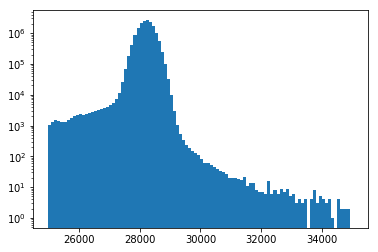

In [31]:
f,ax = plt.subplots(1,1)
h = ax.hist(image_lambda['S02'].getArray().flatten(),bins=100,range=(2.5e4,3.5e4))
ax.set_yscale('log')

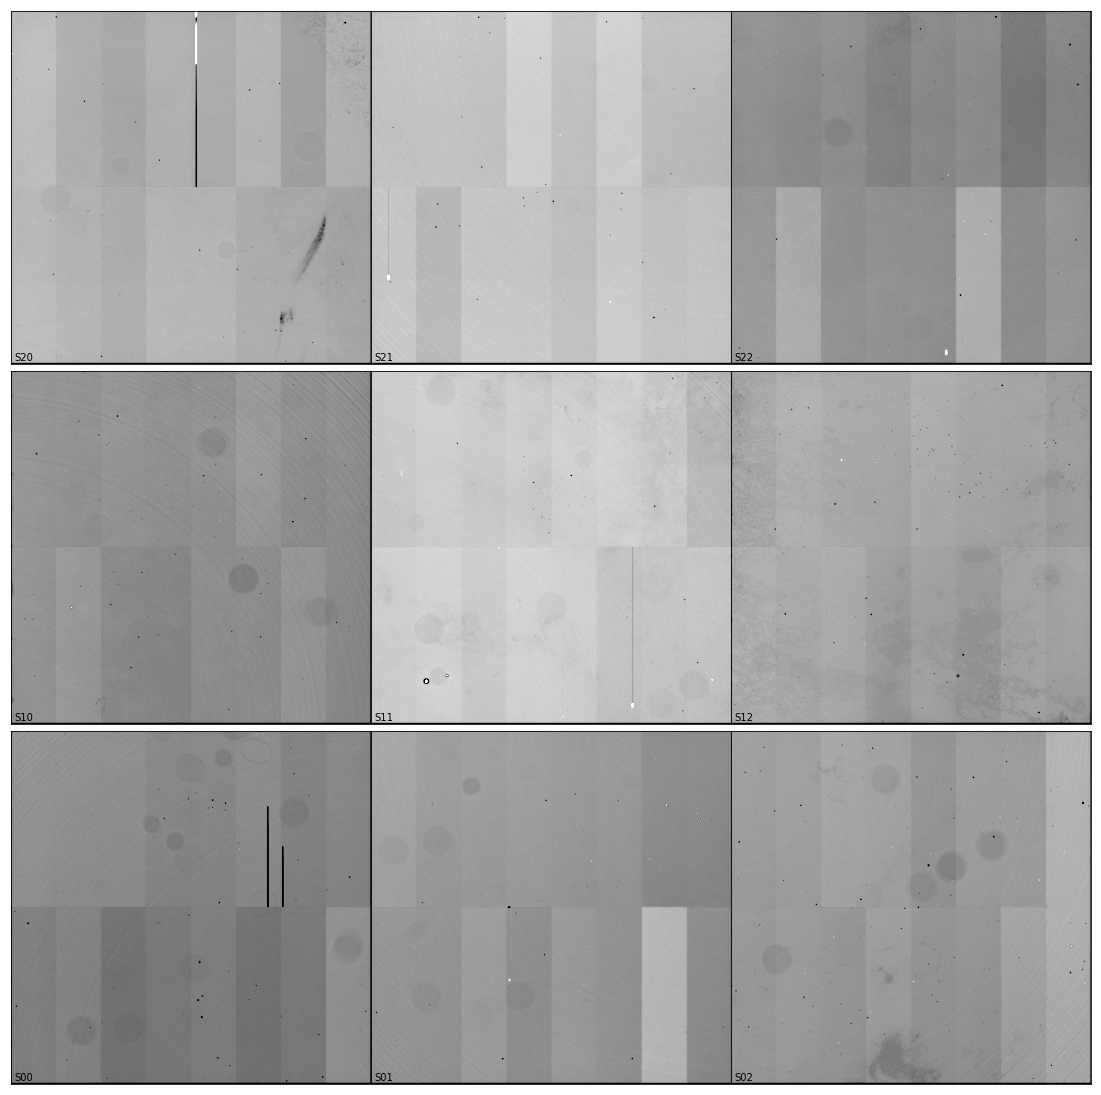

In [32]:
f,axf = plt.subplots(3,3,figsize=(15,15))
ax = axf.flatten()

# matplotlib starts its x,y in the upper left
slotorder = ['S20','S21','S22','S10','S11','S12','S00','S01','S02']
for i in range(9):
    slot = slotorder[i]
    ax[i].imshow(image_lambda[slot].getArray(),origin='lower',interpolation='gaussian',cmap='gray',vmin=2.7e4,vmax=2.9e4)
    ax[i].tick_params(axis='both',which='both',bottom=False,top=False,labelbottom=False,left=False,right=False,labelleft=False)
    ax[i].set_aspect('equal')
    ax[i].text(40.,40.,slot)
    
f.subplots_adjust(hspace=0,wspace=0,left=0.,right=1.,bottom=0.,top=1.)

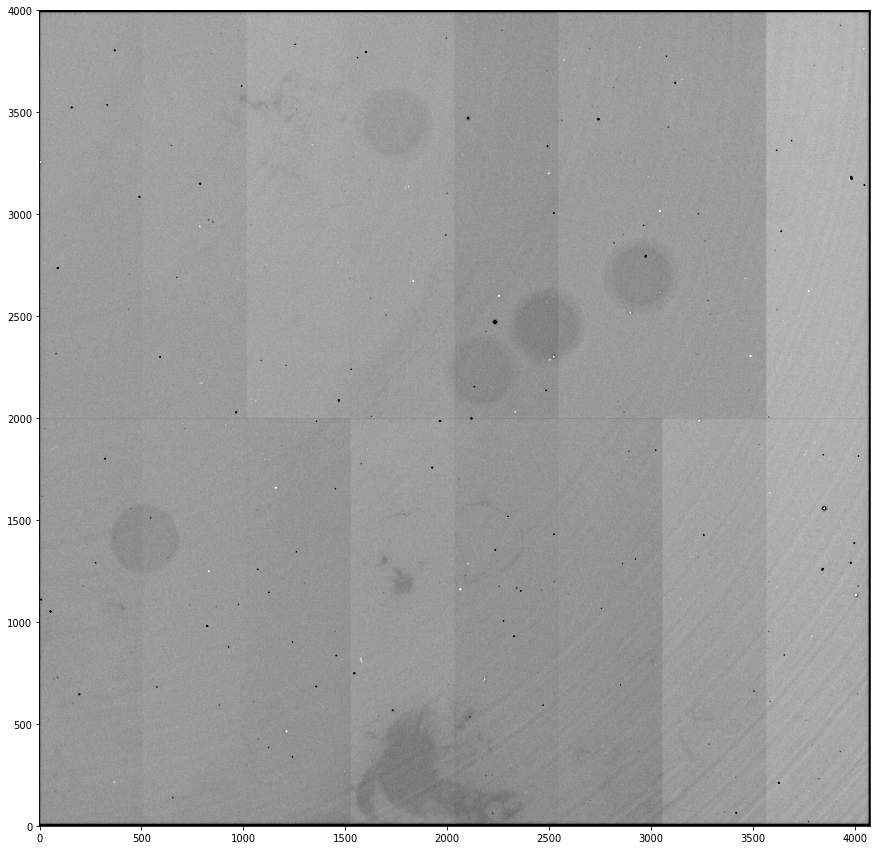

In [33]:
f,ax = plt.subplots(1,1,figsize=(15,15))

slot = 'S02'
ax.imshow(image_lambda[slot].getArray(),origin='lower',interpolation='gaussian',cmap='gray',vmin=2.7e4,vmax=2.9e4)
ax.set_aspect('equal')
    